In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import re
import math
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/Competition/"

In [ ]:
# Imports
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import tensorflow.image as tfimg

In [ ]:
ORIG_IMG_SIZE = (720,1280,3)
Y_CROP = 300
IMG_SIZE = (ORIG_IMG_SIZE[0] - Y_CROP, ORIG_IMG_SIZE[1],ORIG_IMG_SIZE[2])

In [ ]:
folders = ["IMG12", "IMG15", "IMG16", "IMG19", "IMG23", "IMG24", "IMG25", "IMG26"]

paths = []
for folder in folders:
  paths.append(root_path + folder + "/")

In [ ]:
#create ordered lists of images and states for each run

imgLists = []
stateLists = []

for i in range(len(paths)):
  imgLists.append(np.load(paths[i] + "imgList.npy"))
  for j in range(imgLists[i].size):
    imgLists[i][j] = "Image" + imgLists[i][j].partition("Image")[2]

  stateLists.append(np.load(paths[i] + "stateList.npy"))


In [ ]:
#put the image state tuples in lists 

dataLists = []

for i in range(len(paths)):
  dataLists.append([])
  for j in range(imgLists[i].size):
    dataLists[i].append((imgLists[i][j], stateLists[i][j]))

In [ ]:
#shuffle the tuples in each run 

for list in dataLists:
  np.random.shuffle(list)

In [ ]:
#normalize the data lists to have a set number of each state 
#NO NORMALIZING

normalizedDataLists = dataLists

In [ ]:
# img = cv2.imread(paths[0] + normalizedDataLists[0][1000][0], cv2.IMREAD_UNCHANGED)[Y_CROP:]

# scale_percent = 25 # percent of original size
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)



# # resize image
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# plt.imshow(img)

In [ ]:
# img = cv2.imread(paths[0] + normalizedDataLists[0][1000][0], cv2.IMREAD_UNCHANGED)[Y_CROP:]

# scale_percent = 12.5 # percent of original size
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)



# # resize image
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# plt.imshow(img)

In [ ]:

training_set = []


for i in range(len(paths)):
  for j in range(len(normalizedDataLists[i])):

    #skip all stop states
    if np.array_equal(normalizedDataLists[i][j][1], np.eye(4)[0]):
      continue

    #crop the first 300 rows (y values) out
    # Normalize X (images) dataset (need typecast because otherwise converting the ints to float64s would take up too much memory)
    img = cv2.imread(paths[i] + normalizedDataLists[i][j][0], cv2.IMREAD_UNCHANGED)[Y_CROP:]
    
    scale_percent = 12.5 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA).astype(np.float32)/255


    training_set.append((img, normalizedDataLists[i][j][1]))



In [ ]:
np.random.shuffle(training_set)

inputSet = np.array([data[0] for data in training_set])
outputSet = np.array([data[1] for data in training_set])





In [ ]:
stop = 0
left = 0
straight = 0
right = 0

for arr in outputSet:
  if np.array_equal(arr,np.eye(4)[0]):
    stop +=1
  if np.array_equal(arr,np.eye(4)[1]):
    left +=1
  if np.array_equal(arr,np.eye(4)[2]):
    straight +=1
  if np.array_equal(arr,np.eye(4)[3]):
    right +=1

print(stop)
print(left)
print(straight)
print(right)

0
2768
7273
381


### Create neural network

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(height,width,3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (2, 2), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(4, activation='softmax'))

conv_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 158, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 37, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 18, 128)       0

In [ ]:
# #input and ouput shape must match shape of input and expected output shapes
# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(height,width,3)))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(512, activation='relu'))
# #softmax normalizes the output to a probability distribution over predicted output classes
# conv_model.add(layers.Dense(4, activation='softmax'))
# conv_model.summary()

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history_conv = conv_model.fit(inputSet, outputSet, 
                              validation_split=0.2, 
                              epochs=80, 
                              batch_size=32)


Epoch 1/80
261/261 [==============================] - 138s 522ms/step - loss: 0.6895 - acc: 0.7096 - val_loss: 0.6323 - val_acc: 0.7429
Epoch 2/80
261/261 [==============================] - 135s 519ms/step - loss: 0.6171 - acc: 0.7450 - val_loss: 0.6094 - val_acc: 0.7463
Epoch 3/80
261/261 [==============================] - 135s 519ms/step - loss: 0.6058 - acc: 0.7416 - val_loss: 0.6017 - val_acc: 0.7492
Epoch 4/80
261/261 [==============================] - 135s 517ms/step - loss: 0.5937 - acc: 0.7467 - val_loss: 0.6113 - val_acc: 0.7516
Epoch 5/80
261/261 [==============================] - 139s 533ms/step - loss: 0.5824 - acc: 0.7490 - val_loss: 0.5861 - val_acc: 0.7472
Epoch 6/80
261/261 [==============================] - 135s 517ms/step - loss: 0.5771 - acc: 0.7510 - val_loss: 0.5926 - val_acc: 0.7468
Epoch 7/80
261/261 [==============================] - 135s 518ms/step - loss: 0.5718 - acc: 0.7535 - val_loss: 0.5835 - val_acc: 0.7448
Epoch 8/80
261/261 [============================

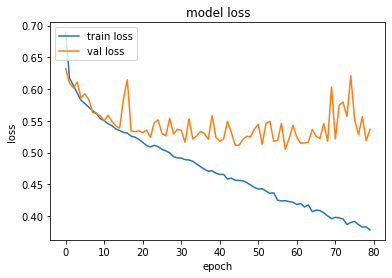

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

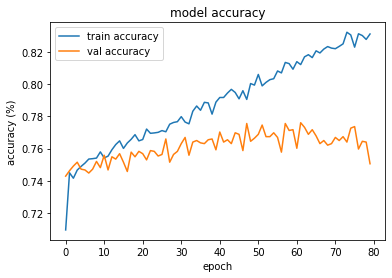

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
conv_model.save(root_path + "NN_8RALL_nostop.h5")